# AirBnb Florence listings_summary
In this notebook we are using AirBnb data, compiled on 11 june 2022 and restircted to the city of Florence (Italy). 
These data are available on the website http://insideairbnb.com/get-the-data/ and they are licenced under a Creative Commons Attribution 4.0 International License (http://creativecommons.org/licenses/by/4.0/).
# Data exploration
We begin with a simple data exploration of the available datasets:
 - **listings.cvs** : Detailed listings data showing 96 attributes for each of the listings. Some of the attributes used in the analysis are price(continuous), longitude (continuous), latitude (continuous), listing_type (categorical), is_superhost (categorical), neighbourhood (categorical), ratings (continuous) among others.
 - **calendar.csv** : Provides details about booking for the next year by listing. 6 attributes in total: listing_id (discrete), date(datetime), available (categorical) and price (continuous), min_nights, max_nights.
 - **reviews.csv** : Detailed reviews given by the guests with 6 attributes. Key attributes include date (datetime), listing_id (discrete), reviewer_id (discrete) and comment (textual).

### Summary datasets
The website provides also 2 summary datasets:
 - **listings_summary.cvs**: listings data already cleaned and preprocessed.
 - **review_dates.csv**: contains only the listing id and the review date. It can be used as a proxy for the number of bookings. It facilitates time based analytics.

We will exploit these 2 datasets in the sandbox analysis phase, but we will assume they are not available when scaling to a big data source, so we will have to obtain any interesting feature we find useful with Hadoop, Spark or other Big Data Tools.

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Review_dates.cvs
As mentioned earlier, we will be using the review dates as a proxy for the actual Airbnb bookings. The assumption is that the the number of reviews correspond to the demand for the rentals on the basis of Airbnb’s claim that 50% of guests review their stay. Furthermore, a review has to be provided by guests within 2 weeks of their stay, hence the number of reviews can provide a good estimate of the demand during a particular period.

In [ ]:
review_dates = pd.read_csv('../datasets/Florence/reviews_dates.csv')
review_dates['date']= pd.to_datetime(review_dates['date'])

For example we can use this file to count how many listings received reviews in each date. Then we expect that this number corresponds to roughly half of the actual rentals that happened around a week before.

In the following graph we oberve:
 - **seasonality** of the demand;
 - a steady (exponential?) growth in the mean until 2020
 - a huge drop in 2020, due to the covid pandemic and the government restriction
 
The data show big fluctuations on a day-to-day basis. When computing the 1 month moving average they are averaged and the seasonality becomes evident. Then when averaging over 1 year we observe only the steady growth in the number of Airbnb users, with the covid drop.

### 2020-today corrected average
If we want to analyze 2020 and 2021, we can compute the average on those years alone, and use that value instead of the moving average. This is sustained by the hypothesis that each of those 2 years was higly influence by external events, but we can assume that those year behaved independently from one another.

We chose as a starting point for this correction the date of 1 april 2020, because the covid pandemic broke out in Italy on 1 march 2020, then we considered the 2 week delay from an actual stay to the review date, and added 2 more weeks as a margin.

Text(0.5, 1.0, 'Number of Reviews: a Proxy for the number of Bookings')

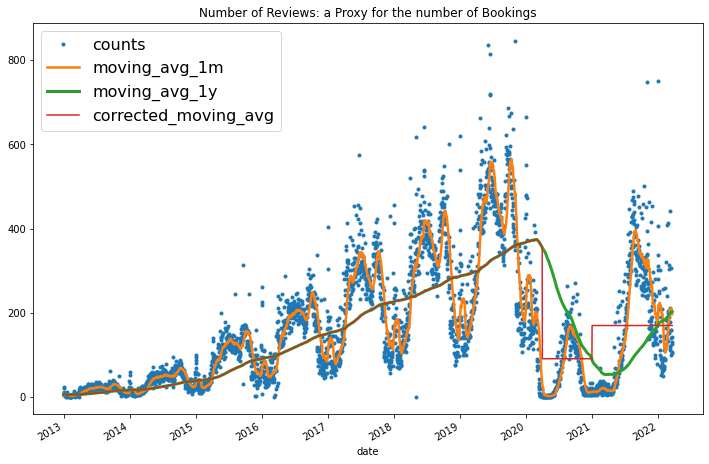

In [ ]:
# count reviews by date, using groupby
# This task can be performed by a MapReduce Job, when dealing 
# with a Big Data Source (i.e. the entire AirBnb Dataset, for every city)
stays_per_day = pd.DataFrame({'counts':review_dates.groupby('date')['listing_id'].count()})
stays_per_day.loc['2013-01-01':].plot(style = '.',figsize=(12,8))

# moving average over 1 month
# nan filled with 1, since if a date is present in this dataset it means it received at least 1 review
stays_per_day['moving_avg_1m'] = stays_per_day['counts'].rolling('30d').mean()#.fillna(1)
stays_per_day.loc['2013-01-01':,'moving_avg_1m'].plot(linewidth = 2.5)

# moving average over 1 year
stays_per_day['moving_avg_1y'] = stays_per_day['counts'].rolling('365d').mean()#.fillna(1)
stays_per_day.loc['2013-01-01':,'moving_avg_1y'].plot(linewidth = 3)

# create new column, equal to the 1 year moving average
stays_per_day['corrected_moving_avg'] = stays_per_day['moving_avg_1y']
# compute average for 2020 and 2021-today by their self
avg_2020 = stays_per_day.loc['2020-01-01':'2021-01-01', 'counts'].mean()
avg_2021 = stays_per_day.loc['2021-01-01':, 'counts'].mean()
# subsitute avg_2020/avg_2021 in the new column
stays_per_day.loc['2020-04-01':'2021-01-01', 'corrected_moving_avg'] = avg_2020
stays_per_day.loc['2021-01-01':, 'corrected_moving_avg'] = avg_2021
# plot the new column
stays_per_day.loc['2013-01-01':,'corrected_moving_avg'].plot(linewidth = 1.5)


plt.legend(fontsize=16)
plt.title('Number of Reviews: a Proxy for the number of Bookings')

## Custom metric: bookings seasonality 2010-2019
To study the **seasonality** I will try to introduce an ad hoc metric, defined as **(counts - mv_avg_1y)/mv_avg_1y**. It is intended to smooth over the growth and represent only the seasonality. This metric can be made even more smooth replacing counts with mv_avg_1m (mv_av_1w doesn't change much).

This metric is not reliable form 2020 to 2022, since the sudden drop due to covid, makes the assumption that moving_avg_1y is a good estimator of the general trend false. So I will not consider that timespan for this analysis.

Text(0.5, 1.0, 'seasonality')

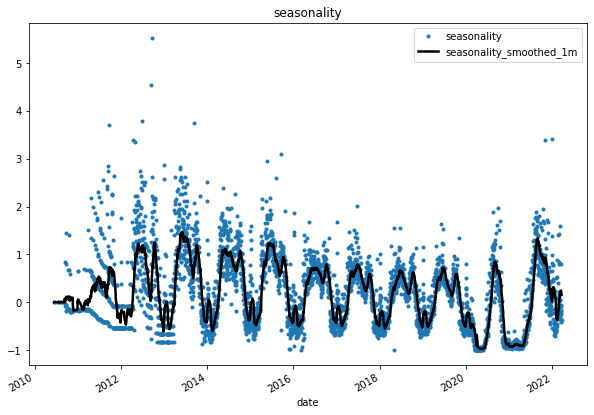

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,7))

stays_per_day['seasonality'] = (stays_per_day['counts']- stays_per_day['corrected_moving_avg'])/stays_per_day['corrected_moving_avg']
stays_per_day.loc['2010-01-01':,'seasonality'].plot(ax = ax, style = '.')

# seasonality smoothed with moving average over 1 month
stays_per_day['seasonality_smoothed_1m'] = (stays_per_day['moving_avg_1m']- stays_per_day['corrected_moving_avg'])/stays_per_day['corrected_moving_avg']
#stays_per_day['seasonality_smoothed_1m'].plot(ax = axs[0], color = 'r')
stays_per_day.loc['2010-01-01':,'seasonality_smoothed_1m'].plot(ax = ax, color = 'black', linewidth = 2.5)
ax.legend()
ax.set_title('seasonality')

# Hypothesis H1
`The "seasonality", in each year, is highly correalted with the one from other years.`

### Testing procedure
First we need to reshape my data.
Then we will compute the Pearson Correlation between columns, which is valid in the assumption that fluctuations in this metric are *normally distributed* across years. 

This assumption is very reasonable in years 2010-2019, but might not hold in 2020, 2021, which were influenced by huge external factors, probably disrupting the normality condition.

So we will compute also the Spearman correlation.

### Data reshape
We put on the rows the 365 days of the year, on the columns the different years, and in their intersection the value of the custom defined bookings seasonality.
 1. Add to the dataframe *stays_per_day* 2 columns: **year** and **day_of_the_year**
 2. **pivot** the dataframe with **index** = *day_of_the_year*, **columns** = *year*, **value** = *seasonality (or seasonality_smoothed_1m)* 

These 2 steps can be carried out, in a more pythonic way, exploiting DatetimeIndex methods.

In [ ]:
bookings_seasonality_over_years = pd.pivot_table(stays_per_day, index = stays_per_day.index.day_of_year, columns = stays_per_day.index.year, values= 'seasonality_smoothed_1m')
#bookings_seasonality_over_years = pd.pivot_table(stays_per_day, index = stays_per_day.index.day_of_year, columns = stays_per_day.index.year, values= 'seasonality')

### Normality check
It is sufficient to create a histogram of the seasonality metric to see if it is normally distributed. The **sns.pairplot()** functions allows to do it and it also gives us a visualization of the correlations. 

It turns out they are not really normally distributed. Thus we used Spearman correlation, since it would be very hard to normalize these kind of distributions.

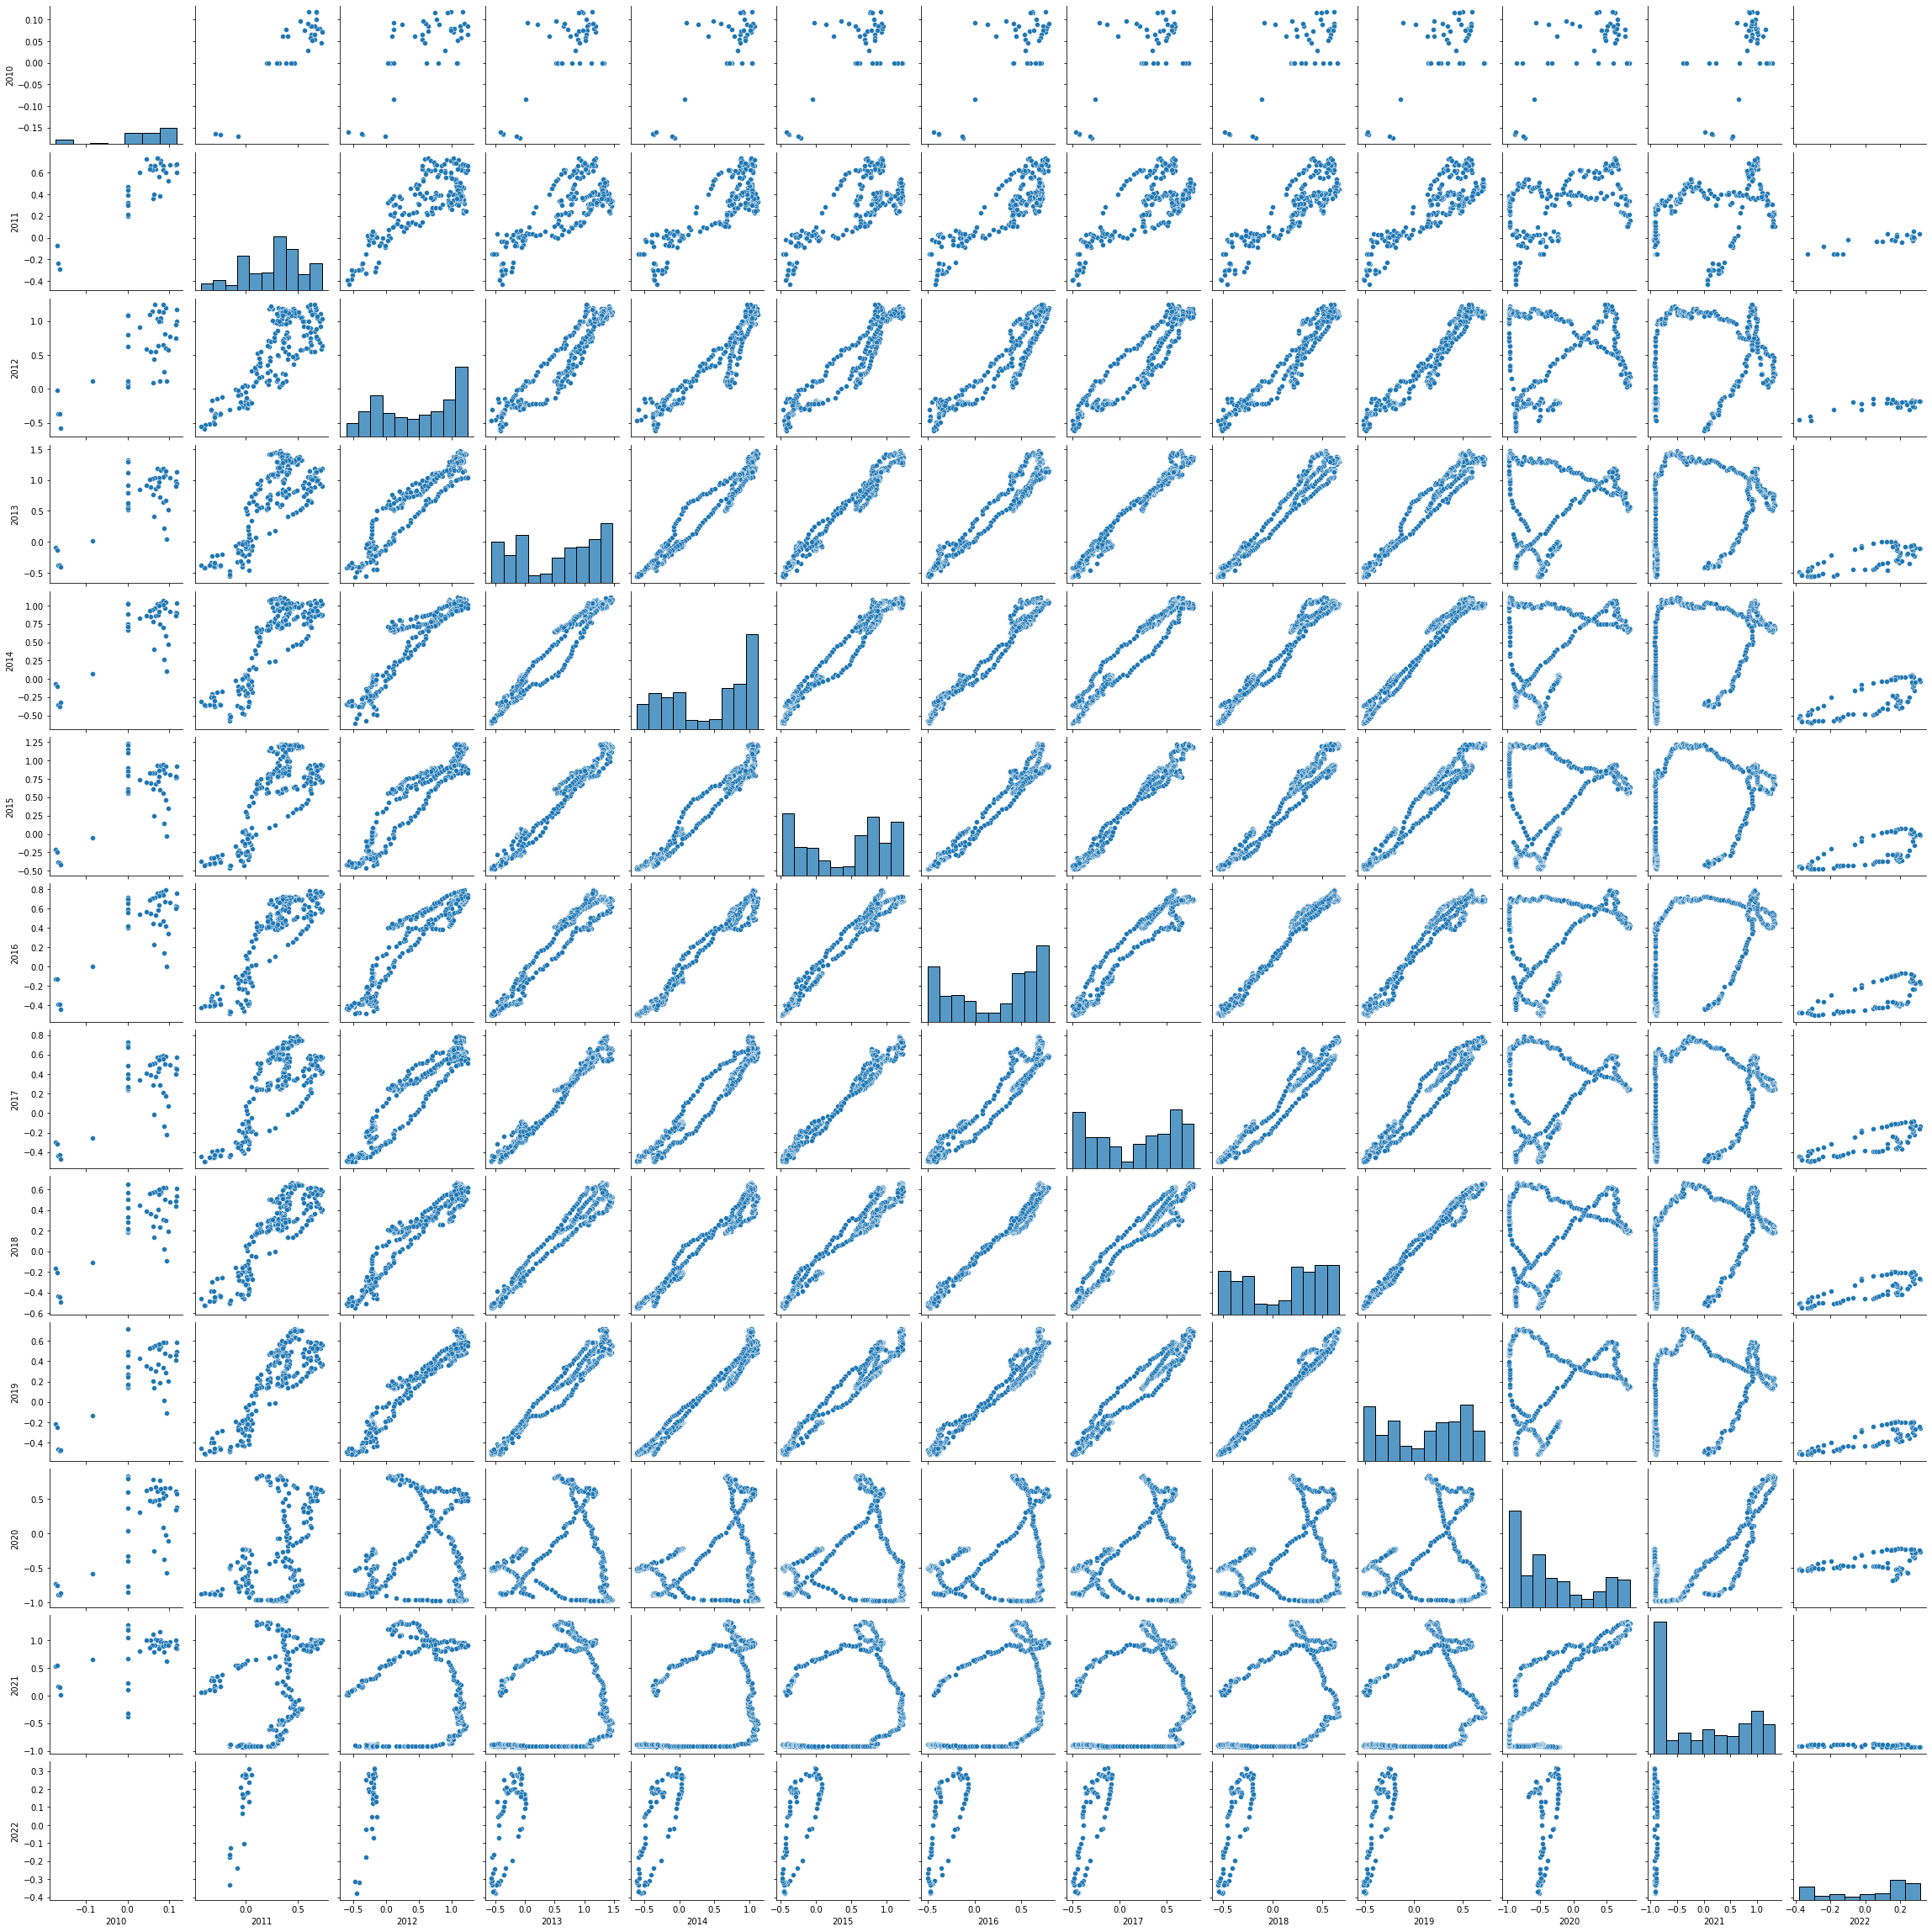

In [ ]:
sns.pairplot(bookings_seasonality_over_years.iloc[:,:])

## Correlations
The pandas DataFrame built-in method does not compute the p-values of the correlation coefficients it computes. Thus we don't have any information about the statistical significance of our findings. 
The solution is to use to *scipy.stats* library instead.

In [ ]:
from scipy.stats import spearmanr

# compute correlations and p_values
corrs, p_values = spearmanr(bookings_seasonality_over_years, nan_policy = 'omit')
# convert results from numpy 2D arrays to pandas DataFrames
corrs = pd.DataFrame(corrs, index = np.arange(2010, 2023), columns = np.arange(2010, 2023))
p_values = pd.DataFrame(p_values, index = np.arange(2010, 2023), columns = np.arange(2010, 2023))

corrs_styled = corrs.style.background_gradient(cmap='coolwarm').format(precision=2)
corrs_styled

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
2010,1.00,0.67,0.39,0.31,0.38,0.24,0.41,0.30,0.41,0.45,0.29,0.23,nan
2011,0.67,1.00,0.67,0.62,0.69,0.67,0.80,0.65,0.83,0.79,0.41,0.49,0.71
2012,0.39,0.67,1.00,0.94,0.95,0.94,0.93,0.92,0.95,0.96,0.01,0.19,0.38
2013,0.31,0.62,0.94,1.00,0.97,0.98,0.93,0.97,0.95,0.96,-0.04,0.25,0.62
2014,0.38,0.69,0.95,0.97,1.00,0.96,0.95,0.94,0.95,0.96,0.04,0.36,0.77
2015,0.24,0.67,0.94,0.98,0.96,1.00,0.96,0.97,0.97,0.97,0.05,0.32,0.73
2016,0.41,0.80,0.93,0.93,0.95,0.96,1.00,0.93,0.98,0.96,0.21,0.47,0.72
2017,0.30,0.65,0.92,0.97,0.94,0.97,0.93,1.00,0.95,0.97,0.02,0.23,0.78
2018,0.41,0.83,0.95,0.95,0.95,0.97,0.98,0.95,1.00,0.99,0.14,0.40,0.77
2019,0.45,0.79,0.96,0.96,0.96,0.97,0.96,0.97,0.99,1.00,0.06,0.35,0.79


## p-values
The Spearman test confronts the 2 alternative scenarios:
 1. **null** hypothesis: there is **NO correlation** between the *seasonality* variable across different years,
 2. **alternative** hypothesis: there is **correlation** between the *seasonality* variable across different years.

The p_value of each computed correlation coefficient is defined as the *probability* that a greater or equal correlation coefficient is found by chance, i.e. if the **null** hypothesis holds.

We fix the **threshold** for **statistical significance** at p = 0.01 (1% probability of having obtained the correlation by chance). If the computed p_values are below that threshold we will discard the *null* hypothesis and accept the *alternative* one.

In [ ]:
p_values_styled = p_values.style.background_gradient(cmap='coolwarm').format(precision=3)
p_values_styled

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
2010,0.000,0.000,0.008,0.033,0.009,0.104,0.004,0.040,0.005,0.002,0.046,0.119,nan
2011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2012,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.923,0.001,0.019
2013,0.033,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.449,0.000,0.000
2014,0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.419,0.000,0.000
2015,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.330,0.000,0.000
2016,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2017,0.040,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.738,0.000,0.000
2018,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.008,0.000,0.000
2019,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.253,0.000,0.000


## Hypothesis H1 validation
The correlation coefficients across years 2012-2019 are all greater than 0.9, with pvalues well below the threshold of p=0.01.
It means that **H1** is **true** for those years.

The remaining years are:
 1. **2010-2011**: here the lack of a clear seasonal pattern can be attributed to the fact that the AirBnb platform just started its operations in this city, and thus the seasonality was not predominant, in confront to other random patterns. **H0** is **false** when relating 2010 and 2011 to any other year.
 2. **2020-2022**: as previously mentioned, here the seasality was disrupted by covid, so in 2020 the correlation is lost (H0 is false), in 2021 and 2022, and in 2021 and 2022 it is partially recovered. If we look at the *seasonality* graph we better understand this result. We can see that in 2020 we have a big central peak, comparable to the one from previous years, but we lost all the remaing information that was contained in the small bumps, which are partially recovered in 2021 and especially in 2022.
 
 
It could be interesting to check wheter the seasonality of other rentals booking services corresponds to the AirBnb one, or if it is unique for each platform.

In [ ]:
reviews = pd.read_csv('../datasets/Florence/reviews.csv')
reviews['date']= pd.to_datetime(reviews['date'])
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,24469,536790507,2019-09-27,238649967,Marina,Excelente trato y atención por parte de los du...
1,24470,102982,2010-09-22,77244,Luciana,We loved to stay at Benedetta and Lorenzo apt....
2,24470,124303,2010-10-22,233800,Steve,A perfect place to spend a week. Amenities wer...
3,24470,440911489,2019-04-21,150908154,Paola,Buona posizione tranquilla e ottima accoglienz...
4,24472,340528,2011-06-28,239905,Michael,Lovely place. Its closeness to the train stati...
...,...,...,...,...,...,...
538859,25002753,286485031,2018-07-06,44907630,Laura,"Daniela è una host eccezionale, che ha saputo ..."
538860,25002753,288967824,2018-07-11,172709277,Eduardo,Daniela es muy amable. El sofá es muy cómodo y...
538861,25002753,290393986,2018-07-14,201386103,Cristian,Daniela è una persona molto gentile e disponib...
538862,25002753,292110398,2018-07-17,202195725,Maria,¡Daniela es encantadora! Me sentí muy acogida ...


# Calendar.csv
This dataset provides details about booking for the next year by listing. We focused on the price distribution (how much each listing costs in each day of the subsequent year).

We had to perform a cleaning process on the price column, since they were provided as strings with $ signs. We eliminated the currency sign and converted the results to integer numbers.

In [ ]:
# clean up dollar signs from prices
def clean_calendar(path):
    calendar = pd.read_csv(path)
    calendar['date']= pd.to_datetime(calendar['date'])
    calendar['price'] = calendar['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    calendar['adjusted_price'] = calendar['adjusted_price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    return calendar

calendar = pd.read_csv('../datasets/Florence/calendar_cleaned/calendar_2022-06-11.csv')
calendar[['listing_id', 'date', 'available', 'price', 'minimum_nights', 'maximum_nights']]

,listing_id,date,available,price,minimum_nights,maximum_nights
0,85820,2022-06-11,f,100.0,2,21
1,85820,2022-06-12,t,100.0,2,21
2,85820,2022-06-13,f,100.0,2,21
3,85820,2022-06-14,f,100.0,2,21
4,85820,2022-06-15,t,110.0,2,21
...,...,...,...,...,...,...
3923015,20078945,2023-06-06,f,195.0,90,90
3923016,20078945,2023-06-07,f,195.0,90,90
3923017,20078945,2023-06-08,f,195.0,90,90
3923018,20078945,2023-06-09,f,195.0,90,90


### Prices distribution
I want to look at the prices distribution across listings. What price correspond to the quantile q? I want to look at the 1% (?) of the most expensive listings.

In [ ]:
# group calendar by listing_id and average the price
avg_prices = pd.DataFrame({'avg_price':calendar.groupby('listing_id')['adjusted_price'].mean()})

## Custom metric: price seasonality
If we only average all the prices in a given day the result is too subject to the fluctuations due to very different range of prices. So we designed this metric that is supposed to smooth over this effect.

Price_seasonality is obtained computing first rel_price = (price-avg_price)/avg_price for every listing_id, then grouping rel_price by date and averaging.

PRICE SEASONALITY DEFINITION:

**It is the average of how much (in %) prices vary, in respect to their average.**

Text(0.5, 1.0, 'Price seasonality')

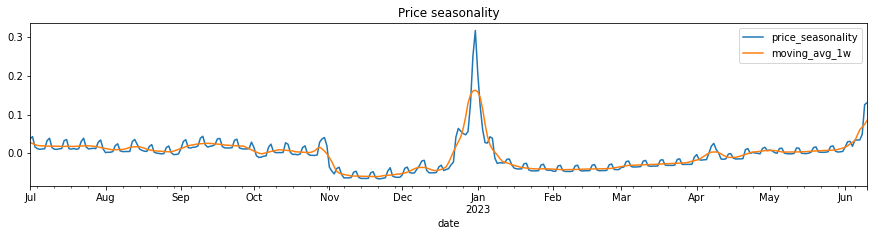

In [ ]:
def compute_price_seas(cal, avg_prices):
    cal_ = pd.merge(cal, avg_prices, how = 'outer', on='listing_id')
    cal_['rel_price'] = (cal_['adjusted_price'] - cal_['avg_price'])/cal_['avg_price']
    return pd.DataFrame({'price_seasonality':cal_.groupby('date')['rel_price'].mean()})

price_seasonality = compute_price_seas (calendar, avg_prices)

price_seasonality.index = pd.to_datetime(price_seasonality.index)
price_seasonality['moving_avg_1w'] = price_seasonality.rolling('7d', center = True).mean()
price_seasonality['price_seasonality - moving_avg_1w'] = (price_seasonality['price_seasonality']-price_seasonality['moving_avg_1w'])
price_seasonality.iloc[20:,:-1].plot( figsize= (15,3))
plt.title('Price seasonality')

Text(0.5, 1.0, 'Weekly variation in price')

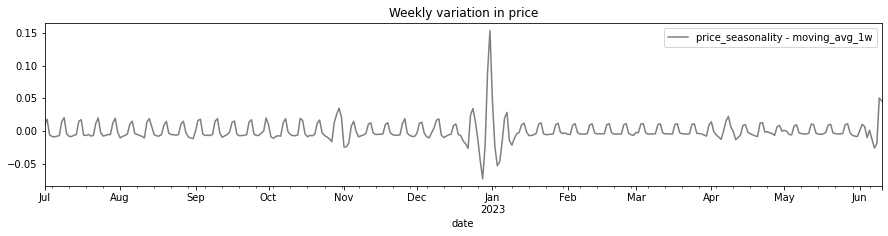

In [ ]:
price_seasonality.iloc[20:,-1].plot( figsize= (15,3), color = 'tab:grey')
plt.legend()
plt.title('Weekly variation in price')

# Hypothesis H2

`It's more expensive to travel in weekends than in weekdays.`

We made a boxplot of the **price_weekday_variation** metric defined above. Since, excluding the outlets (diamond points) the minimum value for Friday and Saturday is greater than the maximum value on all other days. So **H2 is true**.

Text(0.5, 1.0, 'BOXPLOT of weekly price variation')

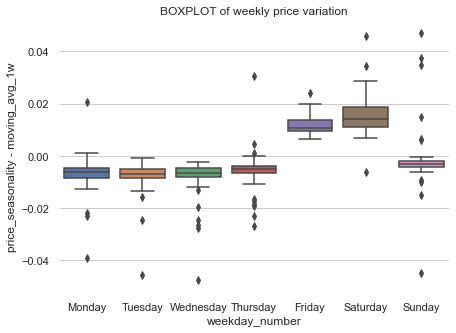

In [ ]:
price_seasonality['weekday_number'] = price_seasonality.index.day_of_week

# translate weekday numbers to weekday names
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

price_seasonality_outlings_cutted = price_seasonality.loc[(price_seasonality['price_seasonality - moving_avg_1w']<0.05) & (price_seasonality['price_seasonality - moving_avg_1w']>-0.05) ]
sns.set(rc={"figure.figsize":(7, 5)}) 
sns.set_style("whitegrid")
sns.boxplot(x = 'weekday_number', y= 'price_seasonality - moving_avg_1w', data =  price_seasonality_outlings_cutted)
sns.despine(left=True, bottom = True)
plt.xticks([0,1,2,3,4,5,6],days)
plt.title('BOXPLOT of weekly price variation')

# Listings_summary.csv

In [ ]:
listings_summary = pd.read_csv('../datasets/Florence/listings_summary.csv')
listings_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10197 entries, 0 to 10196
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              10197 non-null  int64  
 1   name                            10195 non-null  object 
 2   host_id                         10197 non-null  int64  
 3   host_name                       10195 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   10197 non-null  object 
 6   latitude                        10197 non-null  float64
 7   longitude                       10197 non-null  float64
 8   room_type                       10197 non-null  object 
 9   price                           10197 non-null  int64  
 10  minimum_nights                  10197 non-null  int64  
 11  number_of_reviews               10197 non-null  int64  
 12  last_review                     

In [ ]:
listings_summary.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,1.019700e+04,1.019700e+04,0.0,10197.000000,10197.000000,10197.000000,10197.000000,10197.000000,8406.000000,10197.000000,10197.000000,10197.000000
mean,1.404821e+16,1.007203e+08,NaN,43.773953,11.253640,134.644601,4.520741,52.845347,1.247258,11.040796,165.199176,7.262234
std,8.775731e+16,1.173008e+08,NaN,0.009963,0.016757,350.856833,28.923352,86.384343,1.382318,26.020752,122.710706,13.884375
min,2.446900e+04,1.565100e+04,NaN,43.723180,11.147430,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,1.200685e+07,1.192505e+07,NaN,43.768650,11.245600,59.000000,1.000000,2.000000,0.230000,1.000000,42.000000,0.000000
50%,2.470744e+07,4.525968e+07,NaN,43.772580,11.253970,81.000000,2.000000,14.000000,0.750000,3.000000,173.000000,1.000000
75%,4.093138e+07,1.589698e+08,NaN,43.777940,11.261240,125.000000,3.000000,66.000000,1.820000,7.000000,273.000000,8.000000
max,5.852773e+17,4.499975e+08,NaN,43.838780,11.340780,9243.000000,1120.000000,871.000000,11.900000,151.000000,365.000000,199.000000


# Mininum Nights
First we noticed that the minimum nights are 4.52 on average, but with a 28.9 standard deviations. This might be due to the fact that Airbnb offers both short and long term rents, so we want to check wethere there is a clear separation between this two possibilities or if the border is thin. There is also the possibility that a few outliers (the max value for *minimum nights* is 1120) that are strongly influencing this metric.

array([[<AxesSubplot:title={'center':'minimum_nights'}>]], dtype=object)

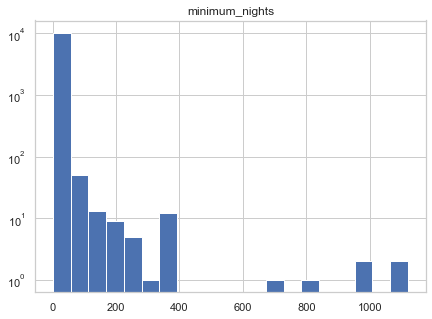

In [ ]:
listings_summary.hist(column= 'minimum_nights', bins= 20, log =True)

In [ ]:
listings_summary[listings_summary['minimum_nights']> 365]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
622,1602088,FlorenceUffiziPonteVecchio2-4pers.,8537173,Sara,NaN,Centro Storico,43.77047,11.25391,Entire home/apt,83,1000,12,2015-07-01,0.12,1,365,0,NaN
2240,10026310,B & B DELUXE ROOM,51479747,Luca,NaN,Centro Storico,43.78295,11.25739,Private room,140,1120,0,NaN,NaN,1,365,0,NaN
3178,15518929,LOVELY APARTMENT VERY NEXT TO THE CENTER A/C W...,73787747,Carlo Clelia,NaN,Campo di Marte,43.76859,11.28597,Entire home/apt,150,720,0,NaN,NaN,2,364,0,NaN
4666,22682534,Modern eco-friendly condo - strategic position,1384542,Francesco,NaN,Isolotto Legnaia,43.77384,11.22335,Entire home/apt,30,800,3,2018-05-08,0.06,2,0,0,NaN
7004,37082244,"「COZY DOUBLE ROOM」Via del Campuccio,88",134082918,Zhuoyi,NaN,Centro Storico,43.76491,11.24252,Private room,6999,1100,1,2019-08-07,0.03,2,150,0,NaN
8522,49201562,B&B Monteverdi di Lorenzo & Francesca,396911707,Francesca,NaN,Centro Storico,43.78595,11.23381,Private room,65,999,10,2022-03-07,1.00,1,35,10,NaN


We found that only 6 listings feature more than 365 (1 year) *minimum_nights*, of which 2 have 0 reviews, 1 has a very high price and 1 has 0 *availabilty_365*.
This means that we can safely treat them as outlings and we can discard them wlog. If we want to apply this filter in general we would have to check this result for at least another city.

array([[<AxesSubplot:title={'center':'minimum_nights'}>]], dtype=object)

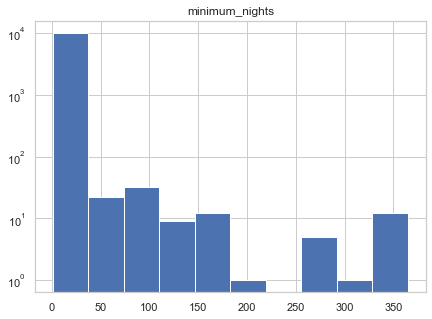

In [ ]:
listings_summary_1year = listings_summary[listings_summary['minimum_nights']< 366]
listings_summary_1year.hist(column= 'minimum_nights', bins= 10, log = True)

array([[<AxesSubplot:title={'center':'minimum_nights'}>]], dtype=object)

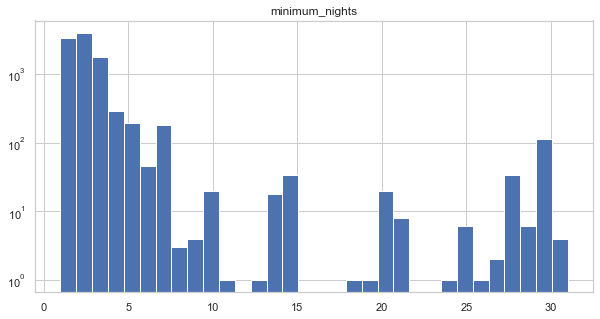

In [ ]:
mn = 32
listings_summary_1year[listings_summary_1year['minimum_nights']< (mn+1)].hist(column= 'minimum_nights', bins=mn , log=True, figsize=(10,5))

array([[<AxesSubplot:title={'center':'minimum_nights'}>]], dtype=object)

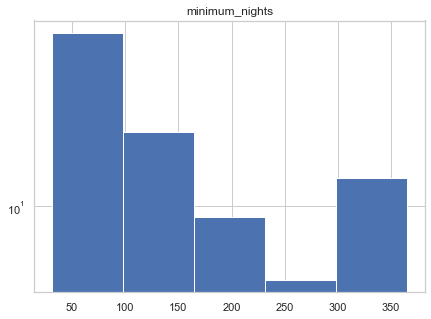

In [ ]:
listings_summary_1year[listings_summary_1year['minimum_nights']> 30].hist(column= 'minimum_nights', bins= 5, log = True)

We can observe a few trends: 
 - there is a peak on 2 minimum nights, followed by a steady exponential (linear in the log scale) decay until we reach 1 week (7 nights).
 - then there are peaks at 15, 21, 28 nights (multiples of a week) and at 30 nights (1 month). This shows that landlords tend to follow the divisions our society introuced in counting days.
 - This is confirmed also when looking at the stays between 1 month and 1 year, at first there is an exponetial (linear in the log scale) decay, followed by a peak at 365 nights (1 year).

## Neighbourhoods and Price
How many neighbourhoods are there in Florence? Which are they? How many listings are there in each one? How is the neighbourhood correlated to the price?

In [ ]:
listings = pd.read_csv('../datasets/Florence/listings.csv')
#listings.info()
listings = listings[['id', 'host_is_superhost', 'accommodates', \
           'bedrooms', 'beds', 'reviews_per_month', 'number_of_reviews_ltm', \
          'review_scores_rating']]
listings_summary = pd.read_csv('../datasets/Florence/listings_summary.csv')
listings_summary = listings_summary[['id', 'neighbourhood', 'room_type', 'price']]
listings_joined = pd.merge(listings, listings_summary)

,id,host_is_superhost,accommodates,bedrooms,beds,reviews_per_month,number_of_reviews_ltm,review_scores_rating,neighbourhood,room_type,price
0,24469,f,4,1.0,1.0,0.03,0,5.00,Centro Storico,Entire home/apt,70
1,24470,f,3,1.0,1.0,0.02,0,4.67,Centro Storico,Entire home/apt,70
2,24471,f,6,2.0,2.0,NaN,0,NaN,Centro Storico,Entire home/apt,135
3,24472,f,6,2.0,2.0,0.02,0,3.00,Centro Storico,Entire home/apt,120
4,26738,f,16,7.0,12.0,0.22,0,4.52,Centro Storico,Private room,149
...,...,...,...,...,...,...,...,...,...,...,...
10192,28666546,f,2,1.0,1.0,0.03,0,5.00,Gavinana Galluzzo,Private room,100
10193,11762656,f,6,3.0,4.0,0.86,1,4.90,Gavinana Galluzzo,Entire home/apt,143
10194,40297561,f,4,2.0,4.0,1.13,9,4.44,Gavinana Galluzzo,Entire home/apt,80
10195,22415145,f,2,1.0,1.0,NaN,0,NaN,Isolotto Legnaia,Entire home/apt,155


Text(0, 0.5, 'price per night (Euro)')

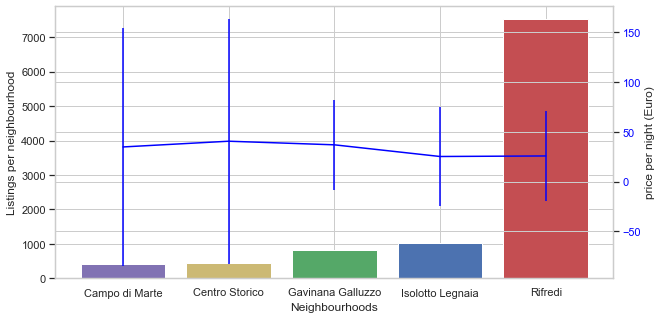

In [ ]:
# number of listings_joined per neighbourhood bar plot
neighbourhood_listings = listings_joined.groupby('neighbourhood')['id'].count().sort_values(ascending=True)

#price per accomodate per neighbourhood
listings_joined['price_per_accomodate'] = listings_joined['price']/listings_joined['accommodates']
neighbourhood_price = listings_joined.groupby('neighbourhood')['price_per_accomodate'].mean()
neighbourhood_price_std = listings_joined.groupby('neighbourhood')['price_per_accomodate'].std()

#plot number of listings per neighbourhood
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(neighbourhood_listings.index, neighbourhood_listings, color = ['m','y','g','b','r'])
plt.xlabel('Neighbourhoods', fontsize = 12)
ax.set_ylabel('Listings per neighbourhood')

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

#plot neighbourhood price
ax2.errorbar(neighbourhood_price.index, neighbourhood_price,yerr=neighbourhood_price_std, color = 'blue')
ax2.tick_params(axis = 'y', labelcolor = 'blue')
ax2.set_ylabel('price per night (Euro)')

## Room Type and Price
How many **room types** are there in Florence? Which are they? How many listings are there in each one? How are they correlated to the price?

room_type
Entire home/apt    382.905145
Hotel room         140.517399
Private room       196.310511
Shared room        522.278527
Name: price, dtype: float64


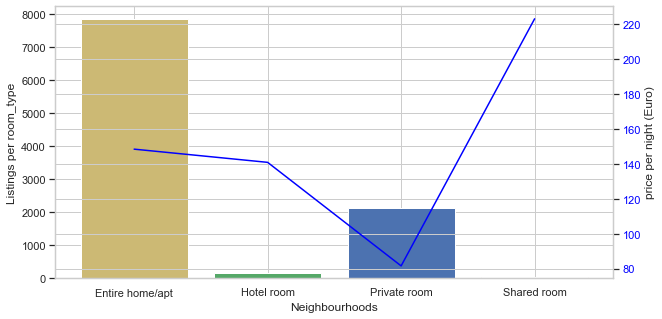

In [ ]:
# number of listings_summary per room_type bar plot
room_type_listings = listings_summary.groupby('room_type')['id'].count()

#price per room_type
room_type_price = listings_summary.groupby('room_type')['price'].mean()

#plot number of listings per room_type
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(room_type_listings.index, room_type_listings, color=['y','g','b','r'])
plt.xlabel('Neighbourhoods', fontsize = 12)
ax.set_ylabel('Listings per room_type')

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

#plot room_type price
ax2.plot(room_type_price.index, room_type_price, color = 'blue')
ax2.tick_params(axis = 'y', labelcolor = 'blue')
ax2.set_ylabel('price per night (Euro)')

# std of prices per room type
room_type_price_std = listings_summary.groupby('room_type')['price'].std()

#print(room_type_price)
print(room_type_price_std)

# Price distribution
we noticed that the most expensive type of room, on average, is the shared room. This is very strange, as we would expect it to be the cheapest. The cause is that there are very few shared rooms, in comparison to other room types, so there is also a very big standard deviation in the price (220 \pm 520). So this result may not be very statistically significant. A better understanding may come from the distribution of the prices, which we will study next.



array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

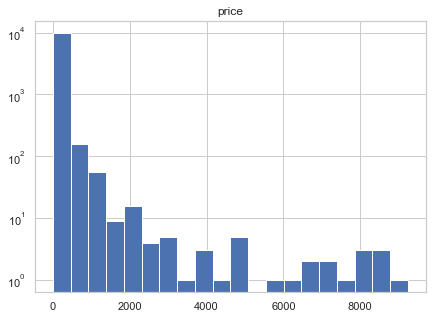

In [ ]:
listings_summary.hist(column= 'price', bins= 20, log =True)

Also in this case most of the listings have a low price, but there are a few that reach even 8000 euros per night. I will study separately these two parts of the distribution.

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

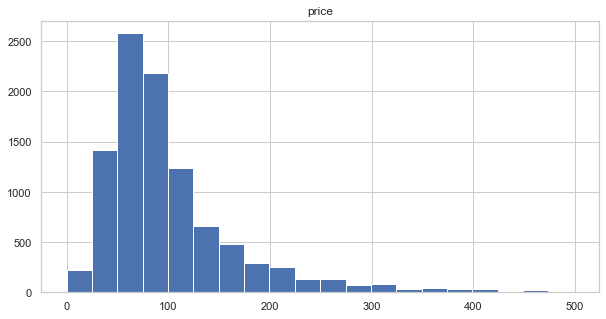

In [ ]:
p = 500
listings_summary[listings_summary['price']< (p)].hist(column= 'price', bins=20 , log=False, figsize=(10,5))

This distribution resembles very closely a poissonian. Let's check whether this is actually the case. This is also consistent with the previous graph. In fact a poissionian distribution usually has few but very big outlings.
A first check is that a poissonian has the same mean and variance.

In [ ]:
print('mean = ' , listings_summary['price'].mean())
print('std = ' , listings_summary['price'].std())

# restriction to prices up to 1200 euros
p=1201
print('mean (restricted) = ' , listings_summary[listings_summary['price']< (p)]['price'].mean())
print('std (restricted) = ' , listings_summary[listings_summary['price']< (p)]['price'].std())

mean =  134.64460135333923
std =  350.8568330033403
mean (restricted) =  112.24733412322274
std (restricted) =  112.30851556719558


It turns out that this is not actually the case, but let's try and fit it.

data mean =  112.24733412322274
fitted poissonian mean =  112.22071165265828


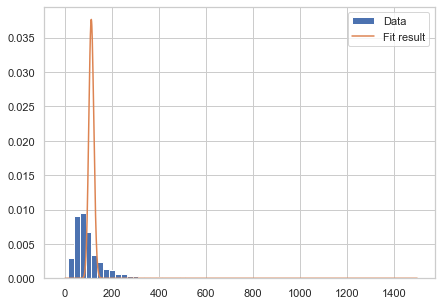

KstestResult(statistic=0.8571428571428571, pvalue=1.0860054711071578e-18)

In [ ]:
#!pip install scipy
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.stats import ks_2samp # to test the statistical significance of the fit
from scipy.stats import kstest

# get poisson deviated random numbers
data = listings_summary[listings_summary['price']< (p)]['price']

# the bins should be of integer width, because poisson is an integer distribution
bins = (np.arange(50) - 0.5)* 25
entries, bin_edges, patches = plt.hist(data, bins=bins, density=True, label='Data')

#print(entries, bin_edges, patches)

# calculate bin centres
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])


def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)

# fit with curve_fit
parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries, p0=data.mean())

print('data mean = ', data.mean())
print('fitted poissonian mean = ', parameters[0])

# plot poisson-deviation with fitted parameter
x_plot = np.arange(0, 1500)
#x_plot = bin_middles

plt.plot(
    x_plot,
    fit_function(x_plot, *parameters),
    #marker='o', linestyle='',
    label='Fit result',
)
plt.legend()
plt.show()

#statistical significance
ks_2samp(entries, fit_function(bin_middles, *parameters))
#kstest(data, 'poisson', args= parameters)

#### Prices are Poissonian? NO

It turns out that the poissonian distribution is not a good approximation for the prices distribution. To confirm this finding I carried out a Kolmogorov Smirnov test.
The null hypothesys **H0** was: the prices follow the Poisson distribution
The alternative hypothesis **H1** was: the prices do not follow the Poisson distribution.

The KS test returned a pvlaue close to 0. The pvlaue is the probability the distance from the observed and expected distribution is greater than the one in our case. So a low pvalue allows to discard the null hypothesis. The prices are not distributed with a poissonian.

# Full listings dataset
We imported *listings.cvs*, which containes the whole available and unfiltered data from the Airbnb website. Then we printed the list of available features. 

We noticed that we don't have a "squared meters" or "price per squared meter" metric, which would be useful to reduce the variance in the prices that I computed above (price per nieghbourhood and price per room type).
The `accomodates`, `beds`, `bathrooms`, `bedrooms feaures`, however, can be used to estimate the domension of a listing. First we checked how much they were correlated to the price.

Also being superhost is associated with greater prices?

In [ ]:
listings = pd.read_csv('../datasets/Florence/listings.csv')
#listings.info()
listings = listings[['id', 'host_is_superhost', 'accommodates', \
           'bedrooms', 'beds', 'reviews_per_month', 'number_of_reviews_ltm', \
          'review_scores_rating']]
listings.info()
listings_summary = listings_summary[['id', 'neighbourhood', 'room_type', 'price']]
listings_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10197 entries, 0 to 10196
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10197 non-null  int64  
 1   host_is_superhost      10195 non-null  object 
 2   accommodates           10197 non-null  int64  
 3   bedrooms               9864 non-null   float64
 4   beds                   10076 non-null  float64
 5   reviews_per_month      8406 non-null   float64
 6   number_of_reviews_ltm  10197 non-null  int64  
 7   review_scores_rating   8406 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 637.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10197 entries, 0 to 10196
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             10197 non-null  int64 
 1   neighbourhood  10197 non-null  object
 2   room_type      10197 no

In [ ]:
# create the listings dataset I will use to estimate the price
def clean_listings(df):
    df.loc[df['host_is_superhost'].isnull(), 'host_is_superhost'] = 0
    df['host_is_superhost'] = df['host_is_superhost'].replace({'t': '1', 'f': '0'}, regex=True).astype(int)

clean_listings(listings)
#listings['host_is_superhost'].sum() #this counts how many superhosts there are

listings_joined = pd.merge(listings, listings_summary)
listings_joined = listings_joined.set_index('id')
listings_joined.describe()

,host_is_superhost,accommodates,bedrooms,beds,reviews_per_month,number_of_reviews_ltm,review_scores_rating,price
count,10197.000000,10197.000000,9864.000000,10076.000000,8406.000000,10197.000000,8406.000000,10197.000000
mean,0.353731,3.777091,1.523216,2.287416,1.247258,7.262234,4.684337,134.644601
std,0.478151,2.052764,0.938583,1.614071,1.382318,13.884375,0.535356,350.856833
min,0.000000,0.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,1.000000,1.000000,0.230000,0.000000,4.610000,59.000000
50%,0.000000,4.000000,1.000000,2.000000,0.750000,1.000000,4.810000,81.000000
75%,1.000000,4.000000,2.000000,3.000000,1.820000,8.000000,4.950000,125.000000
max,1.000000,16.000000,27.000000,17.000000,11.900000,199.000000,5.000000,9243.000000


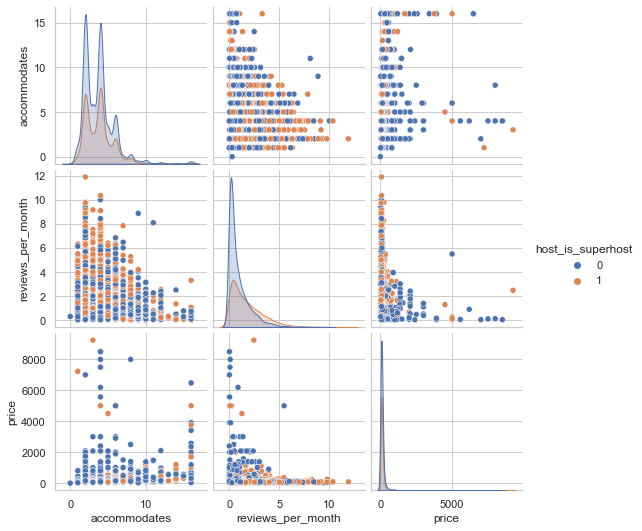

In [ ]:
sns.pairplot(listings_joined[['host_is_superhost','accommodates', 'reviews_per_month', 'price']], hue= 'host_is_superhost')

# Normality
We see from the previous pairplot that our data are not normally distributed, but we can normalize them with a log transformation and  `sklearn.preprocessing.scale()`.

In [ ]:
listings_joined['accommodates'] =  np.log10(listings_joined.accommodates+listings_joined.loc[listings_joined['accommodates']!=0].min().accommodates)
listings_joined['bedrooms'] =  np.log10(listings_joined.bedrooms+listings_joined.loc[listings_joined['bedrooms']!=0].min().bedrooms)
listings_joined['beds'] =  np.log10(listings_joined.beds+listings_joined.loc[listings_joined['beds']!=0].min().beds)
listings_joined['reviews_per_month'] =  np.log10(listings_joined.reviews_per_month+listings_joined.loc[listings_joined['reviews_per_month']!=0].min().reviews_per_month)
listings_joined['review_scores_rating'] =  np.log10(listings_joined.review_scores_rating+listings_joined.loc[listings_joined['review_scores_rating']!=0].min().review_scores_rating)
listings_joined['price'] =  np.log10(listings_joined.price+listings_joined.loc[listings_joined['price']!=0].min().price)
listings_joined['number_of_reviews_ltm'] =  np.log10(listings_joined.number_of_reviews_ltm+listings_joined.loc[listings_joined['number_of_reviews_ltm']!=0].min().number_of_reviews_ltm)


In [ ]:
from sklearn.preprocessing import scale

numerical_columns = ['accommodates','bedrooms','beds','reviews_per_month','review_scores_rating'\
                     ,'price','number_of_reviews_ltm']

for col in numerical_columns:
    listings_joined[col] = scale(listings_joined[col])

listings_joined.describe()

,host_is_superhost,accommodates,bedrooms,beds,reviews_per_month,number_of_reviews_ltm,review_scores_rating,price
count,10197.000000,1.019700e+04,9.864000e+03,1.007600e+04,8.406000e+03,1.019700e+04,8.406000e+03,1.019700e+04
mean,0.353731,-3.846421e-16,-4.916316e-16,-6.473583e-16,2.704897e-17,-2.090446e-17,5.253418e-16,-1.672357e-17
std,0.478151,1.000049e+00,1.000051e+00,1.000050e+00,1.000059e+00,1.000049e+00,1.000059e+00,1.000049e+00
min,0.000000,-3.879343e+00,-6.680517e-01,-1.044182e+00,-2.531721e+00,-8.643683e-01,-1.049631e+01,-3.635231e+00
25%,0.000000,-1.013337e+00,-6.680517e-01,-1.044182e+00,-6.997327e-01,-8.643683e-01,-2.523205e-02,-5.793710e-01
50%,0.000000,3.192796e-01,-6.680517e-01,-1.282629e-02,1.500762e-01,-3.370893e-01,1.874611e-01,-1.558083e-01
75%,1.000000,3.192796e-01,7.818922e-01,7.189325e-01,7.979337e-01,8.070664e-01,3.320339e-01,4.456528e-01
max,1.000000,3.511805e+00,8.769222e+00,4.544760e+00,2.178842e+00,3.166076e+00,3.828440e-01,6.844767e+00


In [ ]:
from scipy.stats import pearsonr

# compute correlations and p_values
corrs = listings_joined.corr()
corrs_styled = corrs.style.background_gradient(cmap='coolwarm').format(precision=2)
corrs_styled

,host_is_superhost,accommodates,bedrooms,beds,reviews_per_month,number_of_reviews_ltm,review_scores_rating,price
host_is_superhost,1.00,0.03,0.00,-0.01,0.29,0.33,0.17,-0.00
accommodates,0.03,1.00,0.73,0.78,0.01,0.03,0.02,0.48
bedrooms,0.00,0.73,1.00,0.75,-0.04,-0.02,0.02,0.47
beds,-0.01,0.78,0.75,1.00,-0.06,-0.03,0.01,0.39
reviews_per_month,0.29,0.01,-0.04,-0.06,1.00,0.67,0.23,-0.11
number_of_reviews_ltm,0.33,0.03,-0.02,-0.03,0.67,1.00,0.13,-0.08
review_scores_rating,0.17,0.02,0.02,0.01,0.23,0.13,1.00,0.00
price,-0.00,0.48,0.47,0.39,-0.11,-0.08,0.00,1.00


In [ ]:
# remove columns higly correlated with each other
del listings_joined['bedrooms']
del listings_joined['beds']
del listings_joined['number_of_reviews_ltm']
# del listings_joined['neighbourhood']
# del listings_joined['room_type']
corrs = listings_joined.corr()
corrs_styled = corrs.style.background_gradient(cmap='coolwarm').format(precision=2)
corrs_styled

,host_is_superhost,accommodates,reviews_per_month,review_scores_rating,price
host_is_superhost,1.00,0.03,0.29,0.17,-0.00
accommodates,0.03,1.00,0.01,0.02,0.48
reviews_per_month,0.29,0.01,1.00,0.23,-0.11
review_scores_rating,0.17,0.02,0.23,1.00,0.00
price,-0.00,0.48,-0.11,0.00,1.00


In [ ]:
# one hot encoding of categorical columns
listings_joined_1hot = pd.get_dummies(listings_joined, columns = ['neighbourhood', 'room_type'])
listings_joined_1hot = listings_joined.fillna(0)

In [ ]:
from sklearn.model_selection import train_test_split

feature_matrix=listings_joined_1hot.loc[:, listings_joined_1hot.columns != 'price']
target_vector=listings_joined_1hot.price

x_train,x_test,y_train,y_test=train_test_split(feature_matrix, target_vector, test_size=0.2, random_state=1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8157, 13)
(2040, 13)
(8157,)
(2040,)


In [ ]:
from sklearn.linear_model import LinearRegression

model=LinearRegression(fit_intercept=True)
model.fit(x_train,y_train)

LinearRegression()

In [ ]:
y_pred_on_training=model.predict(x_train)
y_pred=model.predict(x_test)

In [ ]:
from sklearn import metrics

R2_base=metrics.r2_score(y_train, y_pred_on_training, sample_weight=None, multioutput='uniform_average')
R2=metrics.r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')

print("R2 on training data: ",R2_base)
print("R2 on test data: ",R2)

R2 on training data:  0.3088178999135003
R2 on test data:  0.2581097397487484


The two scores are very **similar**, showing the stability of our model (which does not seem to overfit). Therefore, we do not need any regularization (*Ridge* or *Lasso* regularization).
## Data Understanding
Below the beta coefficients can help us to understand the mode

In [ ]:
coefficients=pd.Series(model.coef_, index=x_train.columns)
print("Intercept: ", model.intercept_)
print("Coefficients: ")
print(coefficients)

Intercept:  -6412957422626.733
Coefficients: 
host_is_superhost                 -6.814679e-03
accommodates                       4.334346e-01
reviews_per_month                 -1.455242e-01
review_scores_rating               2.852155e-02
neighbourhood_Campo di Marte       7.007143e+11
neighbourhood_Centro Storico       7.007143e+11
neighbourhood_Gavinana Galluzzo    7.007143e+11
neighbourhood_Isolotto Legnaia     7.007143e+11
neighbourhood_Rifredi              7.007143e+11
room_type_Entire home/apt          5.712243e+12
room_type_Hotel room               5.712243e+12
room_type_Private room             5.712243e+12
room_type_Shared room              5.712243e+12
dtype: float64


## ML model results
We built a very simple model. When we didn't consider the categorical variables the R2 score was very bad (below .2).

So we added the categorical variables. However now the model coefficients for the neighbourhoods and room types are 10 orders of magnitude greater than the other fields, so our model is basing its prediction only on them.

Maybe this model could be improved if we introduced nonlinearity, and if we increase the size of the dataset.
But we don't think it is worth to invest the resources necessary to extend this model using spark, since its results are not satisfactory.

There are probably other factors, which are not contained in our dataset, that contribute to determine the price of a listing.

Extending the training set with spark would probably not improve the model by much, but it would definetely cost a lot.